<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Prophet" data-toc-modified-id="Prophet-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prophet</a></span></li><li><span><a href="#Дополнительный-признак" data-toc-modified-id="Дополнительный-признак-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Дополнительный признак</a></span></li><li><span><a href="#Разделение-данных-на-обучающую-и-тестовую-выборки" data-toc-modified-id="Разделение-данных-на-обучающую-и-тестовую-выборки-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Разделение данных на обучающую и тестовую выборки</a></span></li><li><span><a href="#Модели-линейной-регрессии-и-градиентного-бустинга" data-toc-modified-id="Модели-линейной-регрессии-и-градиентного-бустинга-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модели линейной регрессии и градиентного бустинга</a></span></li><li><span><a href="#Модель-линейной-регрессии-(дифференцирование)" data-toc-modified-id="Модель-линейной-регрессии-(дифференцирование)-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Модель линейной регрессии (дифференцирование)</a></span></li><li><span><a href="#Модель-линейной-регрессии-(набор-данных-с-дополнительным-признаком)" data-toc-modified-id="Модель-линейной-регрессии-(набор-данных-с-дополнительным-признаком)-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Модель линейной регрессии (набор данных с дополнительным признаком)</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# !pip install scikit-learn==1.2.1 -q # -q убирает необязательные выводы в командах Linux
# !pip install matplotlib==3.8.0 -q
# !pip install pandas==1.5.3 -q
# !pip install seaborn==0.13.0 -q
# !pip install optuna -U -q
# !pip install prophet -q

In [2]:
import logging
import os
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from IPython.display import HTML, display
from lightgbm import LGBMRegressor
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.make_holidays import make_holidays_df
from prophet.plot import add_changepoints_to_plot
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (TimeSeriesSplit, cross_val_score,
                                     train_test_split)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from statsmodels.tsa import stattools
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm

In [3]:
SEED = 12345

display(HTML('<style>.container { width:90% !important; }</style>'))
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)
optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [4]:
def get_df(file_name, idx):
    path_to_file = os.path.relpath(os.path.join('datasets/', file_name))
    if os.path.isfile(path_to_file):
        return pd.read_csv(path_to_file, parse_dates=idx, index_col=idx)
    raise Exception('Данные отсутствуют')

In [5]:
df = get_df('taxi.csv', idx=[0])

True


In [6]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [7]:
df = df.resample('h').sum()
print(df.index.is_monotonic_increasing)

True


**Вывод**:  
- загружен набор данных, содержащий информацию о заказах такси в аэропортах;  
- выполнено ресемплирование по одному часу и проверка на монотонность индекса.

## Анализ

In [8]:
def adf_test(values, alpha=.05):
    stat, p_value = stattools.adfuller(values)[:2]
    print(f'adf = {stat}, p-value = {p_value}')
    if p_value > alpha:
        print('Недостаточно оснований отвергнуть нулевую гипотезу')
    else:
        print('Достаточно оснований отвергнуть нулевую гипотезу')

In [9]:
def plot_num_orders(data):
    data['rolling_mean'] = data['num_orders'].rolling(168).mean()
    data['rolling_std'] = data['num_orders'].rolling(168).std()
    data.plot(figsize=(15, 8), title='График временного ряда')
    plt.ylabel('Количество заказов')
    plt.legend(['Количество заказов', 'Скользящее среднее',
                'Скользящее стандартное отклонение'])
    plt.xlabel('Дата и время');

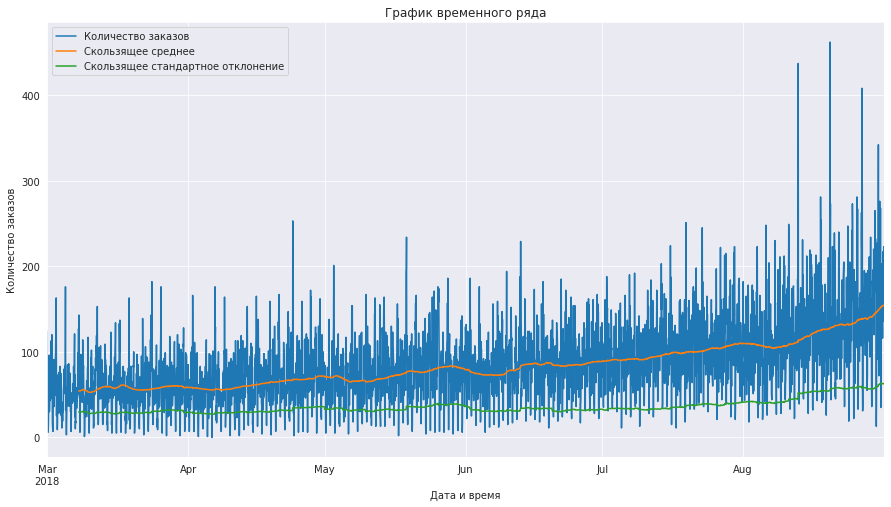

In [10]:
plot_num_orders(df)
df = df.drop(['rolling_mean', 'rolling_std'], axis=1)

In [11]:
adf_test(df['num_orders'])

adf = -3.0689242890279558, p-value = 0.028940051402612906
Достаточно оснований отвергнуть нулевую гипотезу


Стандартное отклонение с течением времени меняется незначительно.    
Несмотря на то, что прослеживается восходящий тренд, есть основания отвергнуть гипотезу о нестационарности временного ряда.

In [12]:
decomposed = seasonal_decompose(df['num_orders'])

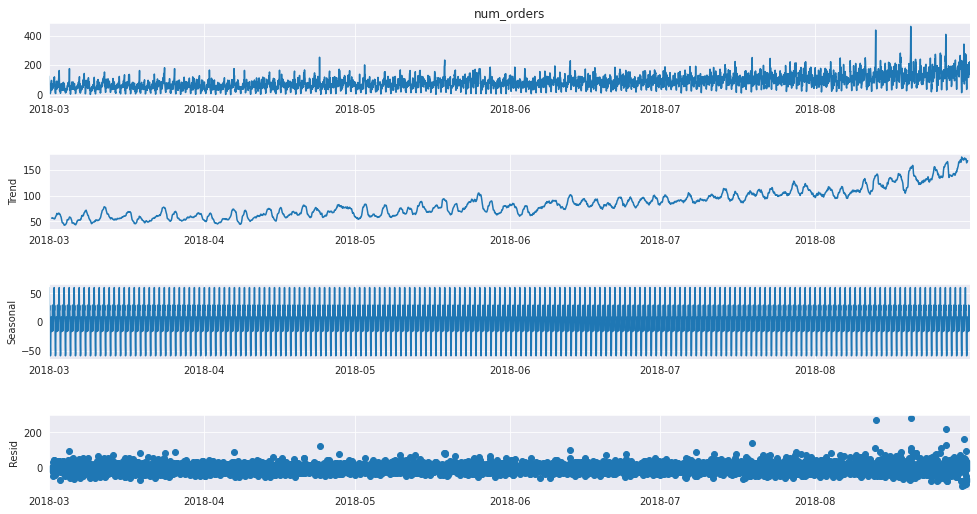

In [13]:
ax = decomposed.plot()
ax.set_size_inches(15, 8);

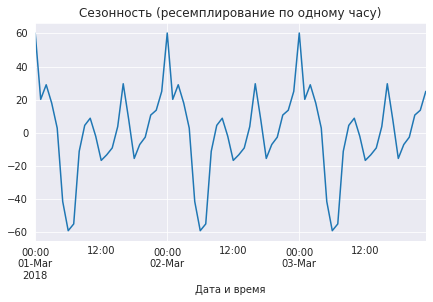

In [14]:
plt.figure(figsize=(7, 4))
decomposed.seasonal[:'2018-03-03'].plot()
plt.title('Сезонность (ресемплирование по одному часу)')
plt.xlabel('Дата и время');

Пик заказов находится в районе 12 часов ночи.  
Наименьшее число заказов приходится примерно на 6 часов утра.

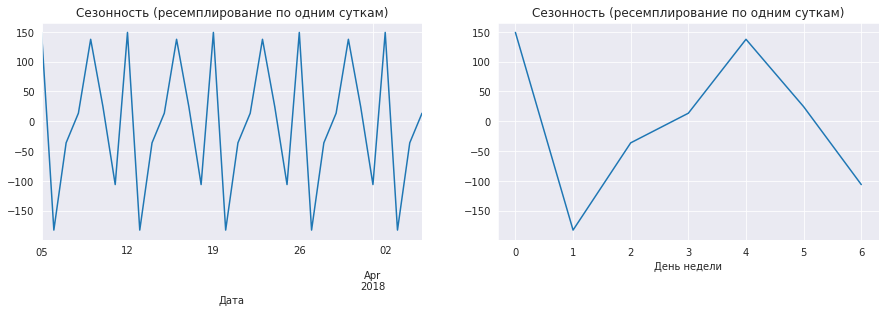

In [15]:
decomposed_days = seasonal_decompose(df.resample('d').sum()['num_orders'])
by_dayofweek = decomposed_days.seasonal['2018-03-05':'2018-03-11']
by_dayofweek.index = by_dayofweek.index.dayofweek
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].set_title('Сезонность (ресемплирование по одним суткам)')
decomposed_days.seasonal['2018-03-05':'2018-04-05'].plot(ax=axs[0])
axs[0].set_xlabel('Дата')
axs[1].set_title('Сезонность (ресемплирование по одним суткам)')
by_dayofweek.plot(ax=axs[1])
axs[1].set_xlabel('День недели');

Пятница и понедельник лидируют по количеству заказов.

Для того чтобы сделать временной ряд более стационарным, применим дифференцирование.

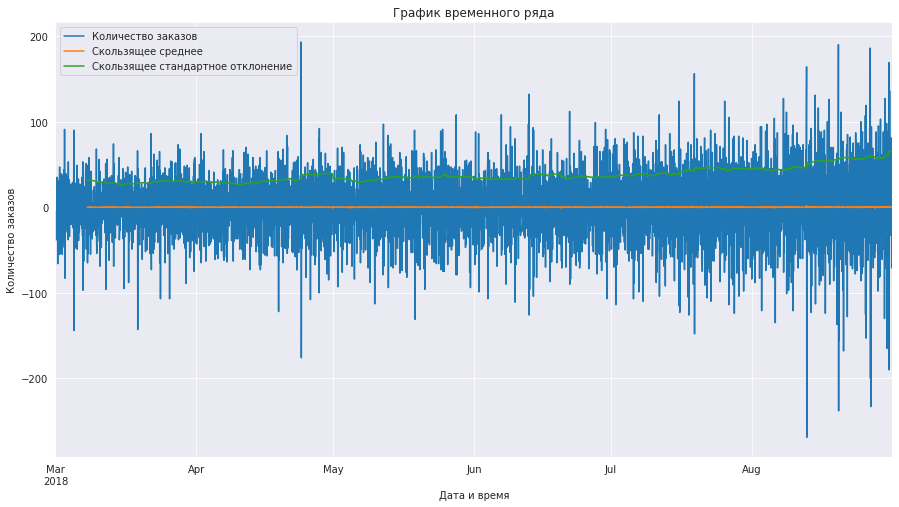

In [16]:
df_diff = df.copy()
df_diff = (df_diff['num_orders'] - df_diff['num_orders'].shift()).to_frame()
plot_num_orders(df_diff)
df_diff = df_diff.drop(['rolling_mean', 'rolling_std'], axis=1)

In [17]:
adf_test(df_diff['num_orders'].dropna())

adf = -15.793234257410534, p-value = 1.0958776746509151e-28
Достаточно оснований отвергнуть нулевую гипотезу


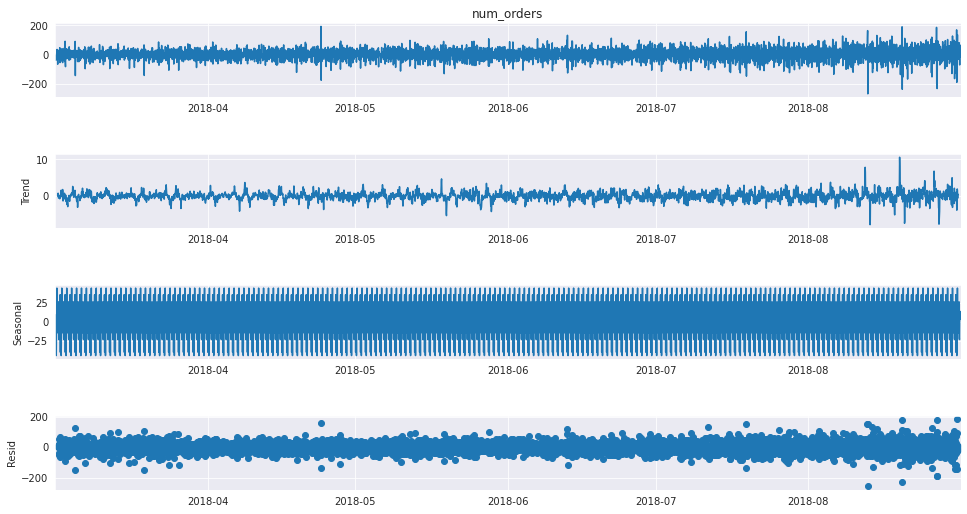

In [18]:
decomposed_diff = seasonal_decompose(df_diff['num_orders'].dropna())
ax = decomposed_diff.plot()
ax.set_size_inches(15, 8);

**Вывод**:  
- достаточно оснований отвергнуть гипотезу о нестационарности временного ряда;   
- прослеживается восходящий тренд, недельная и суточная сезонность;  
- создан датасет с продифференцированным временным рядом.

## Обучение

In [19]:
def get_features_and_targets(data):
    data = data.copy()
    train, test = train_test_split(data, test_size=.1, shuffle=False)
    X_train = train.drop('num_orders', axis=1)
    y_train = train['num_orders']
    X_test = test.drop('num_orders', axis=1)
    y_test = test['num_orders']

    frac = round(test.shape[0] / train.shape[0], 2)
    print(f'Отношение тестовой выборки к обучающей: {frac}')
    print(train.index.min(), train.index.max())
    print(test.index.min(), test.index.max(), '\n')
    return X_train, X_test, y_train, y_test

In [20]:
features_train, features_test, target_train, target_test = \
    get_features_and_targets(df)

Отношение тестовой выборки к обучающей: 0.11
2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00 



### Prophet

In [21]:
df_prophet = df.reset_index(drop=False)
df_prophet.columns = ['ds', 'y']

train_data = df_prophet.iloc[:features_train.shape[0]]
test_data = df_prophet.iloc[features_train.shape[0]:]

ru_holidays = make_holidays_df(year_list=[2018], country='RU')
model = Prophet(daily_seasonality=True, weekly_seasonality=True,
                seasonality_mode='multiplicative', holidays=ru_holidays)
model.fit(train_data)

In [22]:
tscv = TimeSeriesSplit(4)
for elem in tscv.split(train_data):
    print(len(elem[0]), len(elem[1]))

798 794
1592 794
2386 794
3180 794


In [23]:
cv_results = cross_validation(
    model=model,
    initial='797 hours', period='794 hours',
    horizon='794 hours',
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [24]:
max_cv_results = []
prophet_cv_res = []
for i in range(4):
    prophet_cv_res.append(
        performance_metrics(cv_results.iloc[794*i:794*(i+1)],
                            rolling_window=1)['rmse'].values
    )
max_cv_results.append(max(prophet_cv_res)[0])

In [25]:
future = model.make_future_dataframe(periods=test_data.shape[0], freq='h')
forecast = model.predict(future)

In [26]:
mean_squared_error(
    test_data['y'], forecast.loc[test_data.index, 'yhat'], squared=False
)

44.58446134313319

Полученное значение целевой метрики примерно равно 44.64, что удовлетворяет требованию к качеству модели.

### Дополнительный признак

При вызове метода `predict()` модели `Prophet` возвращается датасет.  
Используем его переменную `weekly` в качестве дополнительного признака.

In [27]:
cv_dict = {}
model = Prophet(holidays=ru_holidays)
model.add_seasonality(name='weekly', period=7, fourier_order=100)
model.fit(train_data)
future = model.make_future_dataframe(periods=test_data.shape[0], freq='h')
forecast = model.predict(future)
forecast = forecast.set_index('ds', drop=True)

cv_dict[features_train.shape[0]] = forecast['weekly']
for i in tqdm(range(4)):
    train_upper = 798 + 794 * i
    train_data = df_prophet.iloc[:train_upper]
    test_data = df_prophet.iloc[train_upper:train_upper + 794]
    model = Prophet(holidays=ru_holidays)
    model.add_seasonality(name='weekly', period=7, fourier_order=100)
    model.fit(train_data)
    future = model.make_future_dataframe(periods=test_data.shape[0], freq='h')
    exec(f'forecast_cv_{i+1} = model.predict(future)')
    exec(f'forecast_cv_{i+1} = forecast_cv_{i+1}.set_index("ds", drop=True)')
    exec(f'cv_dict[forecast_cv_{i+1}.shape[0] - test_data.shape[0]] = '
         f'forecast_cv_{i+1}["weekly"]')

100%|██████████| 4/4 [00:18<00:00,  4.57s/it]


In [28]:
(
    forecast_cv_4.shape[0]
    == features_train.shape[0]
    == (forecast_cv_4.index == features_train.index).sum()
)

True

### Разделение данных на обучающую и тестовую выборки

In [29]:
dataframes = {'': df, '_diff': df_diff,}
data_names = ['features_train', 'features_test',
              'target_train', 'target_test']

for name_part, data in dataframes.items():
    print(f'df{name_part}')
    features_targets = get_features_and_targets(data)
    for i in range(len(data_names)):
        exec(f'{data_names[i]}{name_part} = features_targets[{i}]')

df
Отношение тестовой выборки к обучающей: 0.11
2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00 

df_diff
Отношение тестовой выборки к обучающей: 0.11
2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00 



### Модели линейной регрессии и градиентного бустинга

Напишем функцию, которая будет создавать новые признаки.  
Для того чтобы избежать утечки данных, при создании признака `rolling_mean` не будем учитывать текущее значение (используем функцию `shift()`).

In [30]:
def add_features(data, rolling_mean_size, max_lag=24):
    local_df = data.copy()
    col_names = ['dayofweek', 'hour']
    for col_name in col_names:
        local_df[col_name] = getattr(local_df.index, col_name)

    new = {f'lag_{i}': local_df['num_orders'].shift(i).values
           for i in range(1, max_lag+1)}

    local_df = local_df.merge(pd.DataFrame(new, index=local_df.index),
                  left_index=True, right_index=True)

    local_df['rolling_mean'] = \
        local_df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return local_df

In [31]:
class FeaturesExtender(BaseEstimator, TransformerMixin):
    def __init__(self, forecasts=cv_dict):
        self.forecasts = forecasts

    def fit(self, X, y):
        self.size = X.shape[0]
        self.weekly = self.forecasts[self.size]
        return self

    def transform(self, X, y=None):
        lower, upper = 0, self.size
        if X.shape[0] != self.size:
            lower, upper = self.size, self.size + X.shape[0]
        X = X.merge(
            self.weekly.iloc[lower:upper],
            left_index=True, right_index=True,
            how='left'
        )
        return X

In [32]:
class PipelineDropNA(Pipeline):
    
    def fit(self, X, y=None, **params):
        if y is not None:
            X = X.dropna()
            y = y.loc[X.index]

        return super().fit(X, y, **params)

In [33]:
features_train

""
datetime
2018-03-01 00:00:00
2018-03-01 01:00:00
2018-03-01 02:00:00
2018-03-01 03:00:00
2018-03-01 04:00:00
...
2018-08-13 09:00:00
2018-08-13 10:00:00
2018-08-13 11:00:00


In [34]:
def objective(trial, X, y, alpha=(0, 50), reg_al=(1e-2, .2),
              reg_lam=(1e-3, .1), clsmpl_btr=(0.7, 1), sbsmpl=(1e-2, 0.2),
              l_rt=(0.001, 0.01), depth=(20, 30), leaves=(200, 600),
              chld_smpls=(1, 30), cat_sm=(60, 90), extra_feature=False,
              regressor='lr'):
    X_train = X.copy()
    X_train['num_orders'] = y
    rolling_mean_size = trial.suggest_int('rolling_mean_size', 130, 180)
    max_lag = trial.suggest_int('max_lag', 180, 250)
    X_train = add_features(X_train, rolling_mean_size=rolling_mean_size,
                           max_lag=max_lag)
    X_train = X_train.drop('num_orders', axis=1)

    if regressor == 'lgb':
        lgb_params = {
            'n_estimators': trial.suggest_int('n_estimators', 150, 500),
            'reg_alpha': trial.suggest_float('reg_alpha', *reg_al, log=True),
            'reg_lambda':
                trial.suggest_float('reg_lambda', *reg_lam, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree',
                                                    *clsmpl_btr),
            'subsample': trial.suggest_float('subsample', *sbsmpl),
            'learning_rate': trial.suggest_float('learning_rate', *l_rt),
            'max_depth': trial.suggest_int('max_depth', *depth),
            'num_leaves' : trial.suggest_int('num_leaves', *leaves),
            'min_child_samples': trial.suggest_int('min_child_samples',
                                                   *chld_smpls),
            'cat_smooth' : trial.suggest_int('cat_smooth', *cat_sm)
        }
        model = LGBMRegressor(**lgb_params, random_state=SEED, n_jobs=-1)

    else:
        lr_params = {
            'alpha': trial.suggest_int('alpha', *alpha),
            'tol': trial.suggest_float('tol', 1e-4, 5e-4)
        }
        model = Ridge(
            **lr_params,
            random_state=SEED
        )

    encoder = OneHotEncoder(drop='first', handle_unknown='ignore',
                            sparse_output=False)
    transformer = make_column_transformer(
        (encoder, [0, 1]), remainder='passthrough'
    )
    pipe_steps = [('transformer', transformer),
                  ('scaler', StandardScaler()), ('model', model)]
    pipeline = PipelineDropNA(pipe_steps)
    if extra_feature:
        pipeline = make_pipeline(FeaturesExtender(), pipeline)
    result = cross_val_score(
        pipeline, X_train, y,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        cv=TimeSeriesSplit(4),
        error_score='raise'
    )
    return result.min()

In [35]:
# func = lambda trial: objective(trial, features_train, target_train)
# sampler = optuna.samplers.TPESampler(seed=SEED)
# lr_study = optuna.create_study(direction='maximize', sampler=sampler)
# lr_study.optimize(func, n_trials=100, show_progress_bar=True)

In [36]:
# func = lambda trial: objective(trial, features_train, target_train,
#                                regressor='lgb')
# sampler = optuna.samplers.TPESampler(seed=SEED)
# lgb_study = optuna.create_study(direction='maximize', sampler=sampler)
# lgb_study.optimize(func, n_trials=100, show_progress_bar=True)

In [37]:
# lr_best_params = lr_study.best_params
# lgb_best_params = lgb_study.best_params

lr_best_params = {
    'rolling_mean_size': 136,
    'max_lag': 216,
    'alpha': 47,
    'tol': 0.00031816548957865976
}

lgb_best_params = {
    'rolling_mean_size': 178,
    'max_lag': 246,
    'n_estimators': 277,
    'reg_alpha': 0.09906686564937693,
    'reg_lambda': 0.0015319679749569123,
    'colsample_bytree': 0.9335382713256238,
    'subsample': 0.1,
    'learning_rate': 0.0671085578150022,
    'max_depth': 26,
    'num_leaves': 496,
    'min_child_samples': 14,
    'cat_smooth': 72
}

In [38]:
def get_features_and_targets_with_params(data, rolling_mean,
                                         max_lag, best_params):
    data = add_features(data, rolling_mean, max_lag)
    return get_features_and_targets(data)

In [39]:
reg_params = {'lr': lr_best_params, 'lgb': lgb_best_params}
for reg, params in reg_params.items():
    rolling_mean = params.pop('rolling_mean_size')
    max_lag = params.pop('max_lag')
    items = get_features_and_targets_with_params(
        df, rolling_mean, max_lag, params
    )
    for i in range(len(data_names)):
        exec(f'{reg}_{data_names[i]} = items[{i}]')

Отношение тестовой выборки к обучающей: 0.11
2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00 

Отношение тестовой выборки к обучающей: 0.11
2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00 



In [40]:
def get_worst_cv_result(params, regressor='lr',
                        X=lr_features_train, y=lr_target_train):
    encoder = OneHotEncoder(drop='first', handle_unknown='ignore',
                        sparse_output=False)
    transformer = make_column_transformer(
        (encoder, [0, 1]),
         remainder='passthrough'
    )
    if regressor == 'lr':
        model = Ridge(**params, random_state=SEED)
    else:
        model = LGBMRegressor(**params, random_state=SEED,
                              n_jobs=-1, verbose=-1)
    
    pipe_steps = [('transformer', transformer),
                  ('scaler', StandardScaler()), ('model', model)]
    pipe = PipelineDropNA(pipe_steps)
    result = cross_val_score(
        pipe, X, y, scoring='neg_root_mean_squared_error', n_jobs=-1,
        cv=TimeSeriesSplit(4), error_score='raise'
    )
    return -result.min()

In [41]:
%%time
lr_result = get_worst_cv_result(lr_best_params)
# lgb_result = get_worst_cv_result(lgb_best_params, X=lgb_features_train,
#                                  y=lgb_target_train, regressor='lgb')
lgb_result = 28.159963
max_cv_results.extend([lgb_result, lr_result])

CPU times: user 668 ms, sys: 811 ms, total: 1.48 s
Wall time: 1.47 s


In [42]:
models = ['Ridge', 'LGBMRegressor', 'Prophet']
pd.DataFrame(data=max_cv_results[::-1], index=models,
             columns=['RMSE (максимальное значение на кросс-валидации)'])

,RMSE (максимальное значение на кросс-валидации)
Ridge,26.552406
LGBMRegressor,28.159963
Prophet,31.910588


Лучший результат показала модель линейной регрессии – используем её на следующих этапах исследования. 

### Модель линейной регрессии (дифференцирование)

In [43]:
df_diff.head()

,num_orders
datetime,
2018-03-01 00:00:00,NaN
2018-03-01 01:00:00,-39.0
2018-03-01 02:00:00,-14.0
2018-03-01 03:00:00,-5.0
2018-03-01 04:00:00,-23.0


In [44]:
func = lambda trial: objective(trial, features_train_diff, target_train_diff,
                               alpha=(0, 5))
sampler = optuna.samplers.TPESampler(seed=SEED)
diff_study = optuna.create_study(direction='maximize', sampler=sampler)
diff_study.optimize(func, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [45]:
item = max_cv_results.pop()
max_cv_results.append(-diff_study.best_value)
max_cv_results.append(item)

### Модель линейной регрессии (набор данных с дополнительным признаком)

In [46]:
func = lambda trial: objective(trial, features_train, target_train,
                               extra_feature=True)
sampler = optuna.samplers.TPESampler(seed=SEED)
weekly_study = optuna.create_study(direction='maximize', sampler=sampler)
weekly_study.optimize(func, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [47]:
max_cv_results.append(-weekly_study.best_value)

In [48]:
models = ['Ridge (дополнительный признак)', 'Ridge',
          'Ridge (дифференцирование)', 'LGBMRegressor', 'Prophet']
pd.DataFrame(data=max_cv_results[::-1], index=models,
             columns=['RMSE (максимальное значение на кросс-валидации)'])

,RMSE (максимальное значение на кросс-валидации)
Ridge (дополнительный признак),26.003834
Ridge,26.552406
Ridge (дифференцирование),26.723455
LGBMRegressor,28.159963
Prophet,31.910588


**Вывод**:  
- исследовано три модели: `Prophet`, `LGBMRegressor` и `Ridge`;  
- на кросс-валидации лучший результат продемонстрировала модель линейной регрессии;  
- наименьшее значение метрики `RMSE` удалось получить, используя при обучении модели датасет с дополнительным признаком `weekly`.

## Тестирование

In [49]:
best_params = weekly_study.best_params

items = get_features_and_targets_with_params(
    data=df, rolling_mean=best_params.pop('rolling_mean_size'),
    max_lag=best_params.pop('max_lag'), best_params=best_params
)
features_train, features_test, target_train, target_test = items

Отношение тестовой выборки к обучающей: 0.11
2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00 



In [50]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore',
                        sparse_output=False)
transformer = make_column_transformer(
    (encoder, [0, 1]),
     remainder='passthrough'
)

In [51]:
model = Ridge(**best_params, random_state=SEED)
pipe = PipelineDropNA(
    [
        ('transformer', transformer),
        ('scaler', StandardScaler()),
        ('model', model)
    ]
)
test_pipe = make_pipeline(FeaturesExtender(), pipe)
test_pipe.fit(features_train, target_train)
predicted = test_pipe.predict(features_test)

In [52]:
mean = target_test.mean().round(2)
r2 = round(r2_score(target_test, predicted), 2)
rmse = round(mean_squared_error(target_test, predicted, squared=False), 2)
data = {'Среднее значение тестовой выборки': mean, 'R2': r2, 'RMSE': rmse}
pd.DataFrame(data=data, index=['Ridge'])

,Среднее значение тестовой выборки,R2,RMSE
Ridge,139.56,0.68,33.3


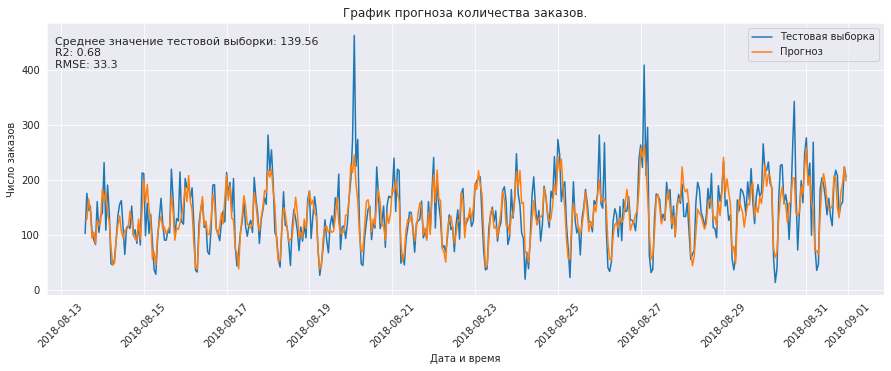

In [53]:
predictions = pd.Series(predicted, index=target_test.index)

plt.figure(figsize=(15, 5))
plt.title('График прогноза количества заказов.')
plt.xlabel('Дата и время')
plt.ylabel('Число заказов')
plt.plot(target_test, label='Тестовая выборка')
plt.plot(predictions, label='Прогноз')
plt.xticks(rotation=45, ha='center')

text = (f'Среднее значение тестовой выборки: {mean}\n'
        f'R2: {r2}\nRMSE: {rmse}')
props = dict(alpha=0)
ax = plt.gca()
ax.text(0.01, 0.95, text, transform=ax.transAxes, fontsize=11,
               verticalalignment='top', bbox=props)
plt.legend();

**Вывод**:  
- у модели возникают трудности с прогнозированием пиковых значений целевого признака;
- качество модели удовлетворяет запросу заказчика: значение метрики `RMSE` ниже 48.

## Общий вывод

**Описание данных**  
`taxi.csv` - датасет, содержащий информацию о заказах такси в аэропортах.  
Количество заказов находится в столбце `num_orders`.  

**Ход исследования**:  
- загружены данные и выполнено их ресемплирование по одному часу;  
- выполнен анализ:   
    - в данных прослеживается недельная и дневная сезонность;  
    - достаточно оснований отвергнуть гипотезу о нестационарности временного ряда;  
    - создан датасет с продифференцированным временным рядом;  
- данные разделены на обучающую и тестовую выборки в соотношении 9:1;  
- выполнен подбор гиперпараметров для трёх моделей: `Prophet`, `LGBMRegressor` и `Ridge`;  
- на кросс-валидации лучший результат продемонстрировала модель линейной регрессии,  
поэтому была выбрана для дальнейшего исследования;  
- наименьшее значение метрики `RMSE` удалось получить, обучая модель на датасете с дополнительным признаком `weekly` (соответствующая переменная извлечена из набора данных, который возвращается при вызове метода `predict()` класса `Prophet`);  
- проведено финальное тестирование: `RMSE` = 33.3.